In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Questions
- How to put the text of some undefined length to the model? (should some cutting be performed, if so, how?)
- 

## Where was it used?
- 7 (2015), - 2008-2014 (1600 programmers); 
- 8 (2020) - ????
- 15 (2019) - 2008-2016
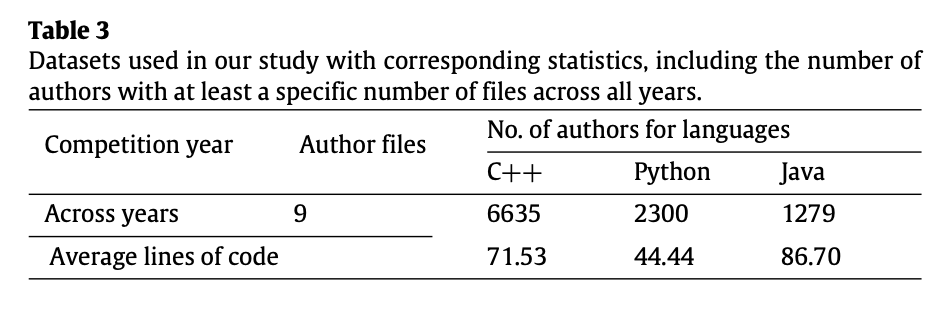
- 16 (2018) - 2008-2016
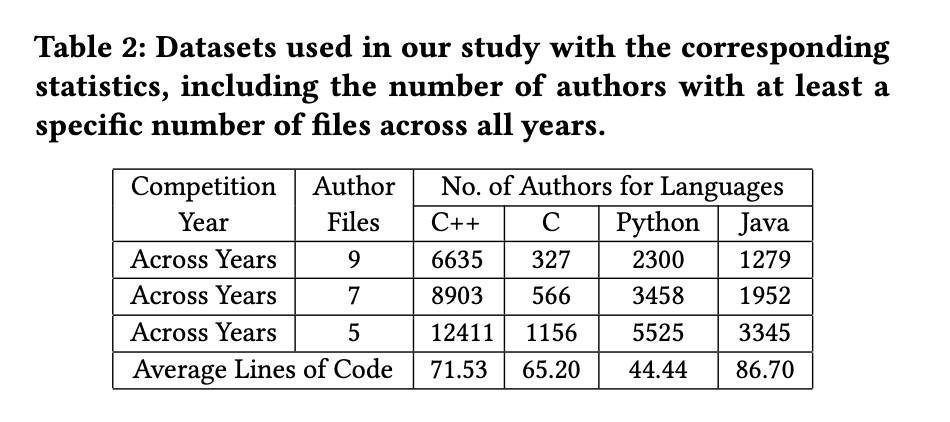

Datasets used in [15] and [16] are the same

## Statistics, which should be collected
- list of languages
- per language and year total amount of files
- amount of participants each year
- amount of files per participant per year: min/max/avg

## Tasks for a week

- [ ] enbeddings for code
- [ ] triplet loss as alternative for classification
- [ ] process of data flow: list
- [ ] plot as much as possible, about the PY-CPP-JAVA data:
    - authors distribution per language per year and total
    - (files per author)  per language and year distribution 
    - file length (lines of code and chars) per year, and lang

## What should be done (for each dataset):

1. Add column with extensions
2. Fileter out authors, who wrine only in one language: ".cpp", ".java", ".py" or ".c"
3. Remove invalid submitions (solution == 0) **????**
4. Group by user, count submitions

## Quesrions about datasets
- Will invalid/old solutions removal make any affect on the accuracy? Now there are probably some files, which are approximately the same, which could potentially lead to overfitting
- Should the models learn each language individually, or their composition would be better?
    + Individually - data is in balance, could learn deep features for each language
    + Composition - some features, which are repitted among languages could be learned. However the problem of data inbalance should be solved.
- Which threshold should be selected as the lowes boundaty of amount of files?  [5, 7, 9]???
- Which languages it reasonable to select? Should they even be filtered? Less languages - less data, more languages - more complex features could be extracted.


## Per-year statistics

In [2]:
# global variables
LANGUAGES = ["cpp", "java", "py"] # c and cs are rare (Could be added)
FILES_PER_USER = 1
YEAR_LIMIT = 2020

In [3]:
def preprocess(df):
    if('Unnamed: 0' in df.columns):
        df = df.drop(columns=['Unnamed: 0'])
    # add column with extensions
    df["lang"] = df.file.apply(lambda x: x.split('.')[-1])
    # for 2018+     
    df.lang = df.lang.map({"cpp":"cpp", 
                           "py":"py",
                           "java":"java", 
                           "c":"c", 
                           "cs":"cs",
                           "CSHARP":"cs",
                           "CS":"cs",
                           "CPP":"cpp",
                           "JAVA":"java", 
                           "PYTHON":"py", 
                           "PYTHON3":"py", 
                           "C":"c"})
    # remove other languages
    df = df[df["lang"].isin(LANGUAGES) == True]
    # remove invalid solutions
    #df = df[df.solution==1]
    # filter users with small amount of files     
    users = (df.groupby(by="username").count()["lang"]>=FILES_PER_USER)
    users = users[users]
    df = df[df.username.isin(users.index)==True]
    return df

In [4]:
# table = []
# for year in tqdm(range(2008, YEAR_LIMIT+1)):
#     df = pd.read_csv("./gcj-dataset/gcj{}.csv".format(year),  low_memory=False)
#     df = preprocess(df)
    
#     # for each person find the most common language
#     users = df.groupby(by=["username"])["lang"].agg([("main_lang", lambda x: x.value_counts().index[0]) ])
#     # dictionary name - language
#     main_langs = {name: users[users.index==name].main_lang[0] for name in users.index}
#     # new column with main language
#     df["main_lang"] = [main_langs[user] for user in df.username]
#     # rm those, who use non-main language
#     df = df[df.lang==df.main_lang]
#     # find files per language
#     users_per_lang = users["main_lang"].value_counts()
#     table.append(users_per_lang)

# display = pd.DataFrame(columns=LANGUAGES, index=list(range(2008, YEAR_LIMIT+1)),  data=table)

# display

# # print(df.flines[0])

# display.sum()

If limit is 2020
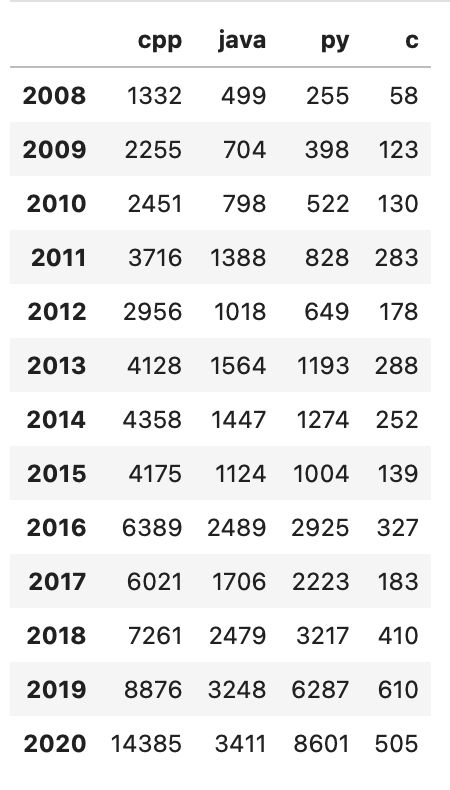
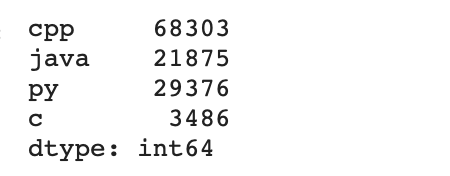

As it could be seen, in the data, used in [15], [16], the numbers are lower. Possible solution - combine datasets and only then group by username

## Joined datasets 2008-2016

Why is it better? we can capture the individuals, who have sibmitted their work a few years a row

In [5]:
df = pd.read_csv("./gcj-dataset/gcj{}.csv".format(2008))

In [6]:
for year in tqdm(range(2009, YEAR_LIMIT+1)):
    df_new = pd.read_csv("./gcj-dataset/gcj{}.csv".format(year),  low_memory=False)
    df = pd.concat([df, df_new], ignore_index=True, sort=False)

100%|██████████| 12/12 [01:22<00:00,  6.88s/it]


In [7]:
df = preprocess(df) # remove other langs and small amount of files

users_per_lang = [df[df.lang==language].username.count() for language in LANGUAGES]
print("C++ users:\t", users_per_lang[0])
print("Java users:\t", users_per_lang[1])
print("Python users:\t", users_per_lang[2])

C++ users:	 1163431
Java users:	 402466
Python users:	 533766


In [8]:
years = list(range(2008, YEAR_LIMIT+1))

def plot_bar(data_per_lang:dict, title, y_label, filename):
    i = 1
    figure = plt.figure(figsize=(15, 5))
    ax = figure.add_axes([0,0,1,1])
    plt.title(title)
    plt.xticks(years)
    plt.xlabel("year")
    plt.ylabel(y_label)
    for lang in LANGUAGES:
        i+=1
        ax.bar(np.array(years)+0.25*i-0.75, data_per_lang[lang], label="{} lang".format(lang), width=0.25)
    plt.legend()
    figure.savefig("./imgs/"+filename, pad_inches=1, bbox_inches ="tight" )
    return figure
    

In [9]:
# collect the statistics about this data
# authors distribution per language per year and total 
authors_data = { lang: [np.unique(df[(df.year==year) & (df.lang==lang)].username).shape[0] 
                    for year in years] 
            for lang in LANGUAGES}

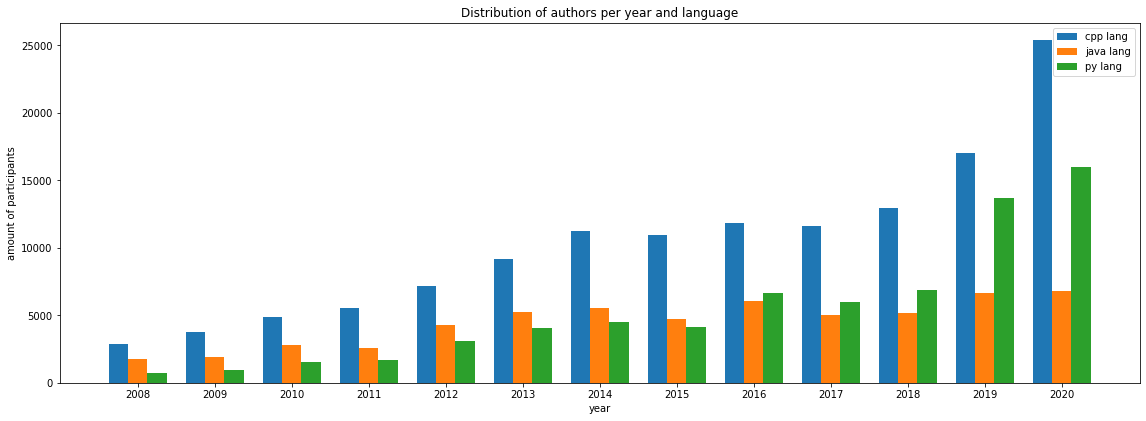

In [10]:
title = "Distribution of authors per year and language"
f = plot_bar(authors_data, title, "amount of participants", "authors.png")
plt.show()

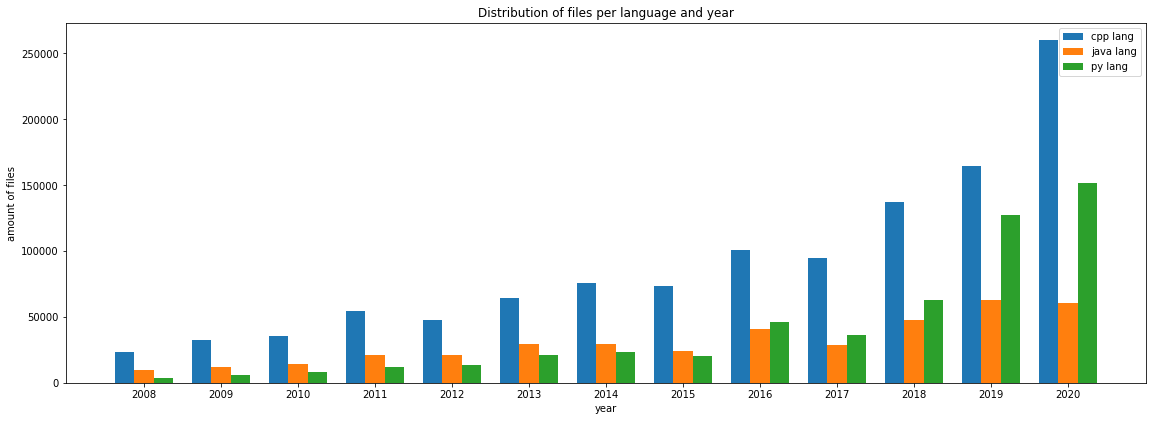

In [11]:
# files per language and year
files_data = {lang: [df[(df.year==year) & (df.lang==lang)].file.count() for year in years] for lang in LANGUAGES}
plot_bar(files_data, "Distribution of files per language and year", "amount of files", "files")

plt.show()

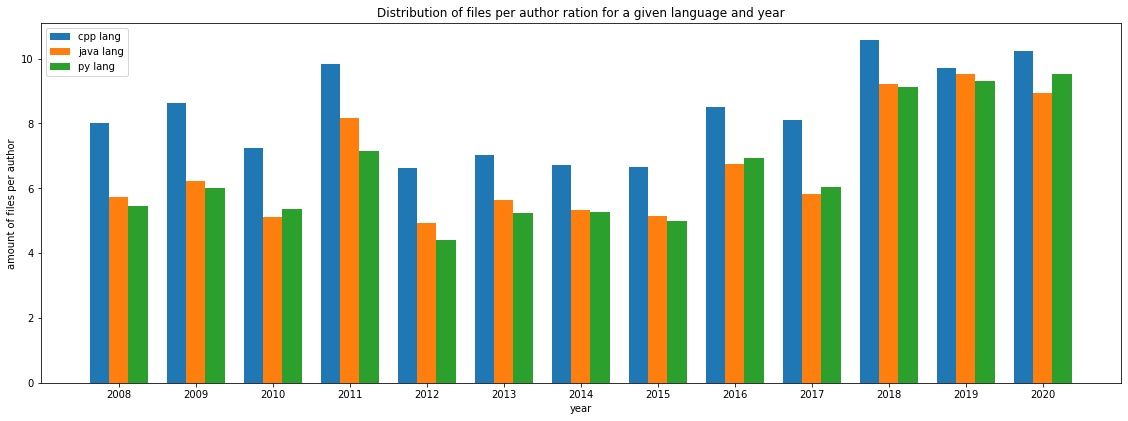

In [12]:
#     - (files per author)  per language and year distribution 
files_per_author_data = {lang: [files_data[lang][i]/authors_data[lang][i] 
                                for i in range(YEAR_LIMIT-2008+1)] 
                         for lang in LANGUAGES}
plot_bar(files_per_author_data, 
        "Distribution of files per author ration for a given language and year", 
        "amount of files per author", "files_per_author")

plt.show()

**Dicsussion:**
- the file-author ratio is approximately constant across years, 
- the avg value is around 5 
- for c++ language this ratio is usually higher

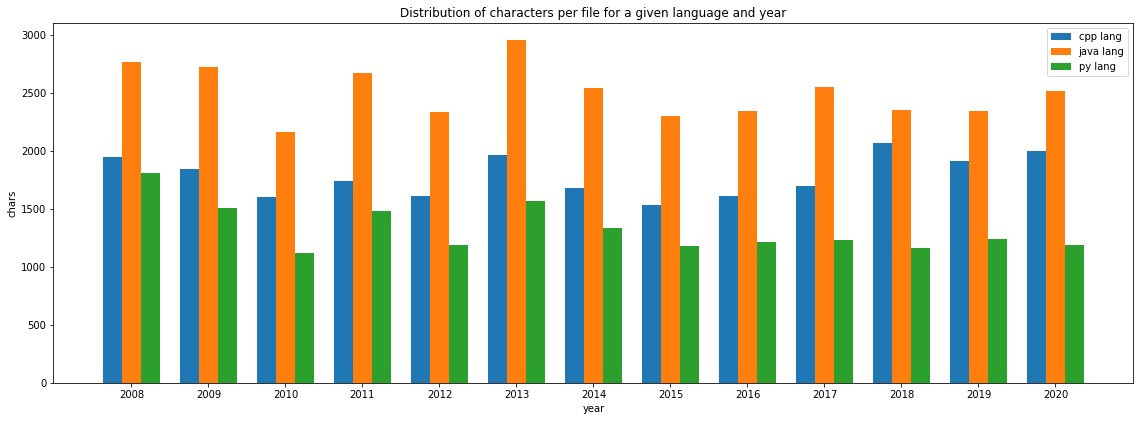

In [13]:
#     - file length (lines of code and chars) per year, and lang
chars_data= {lang: [df[(df.year==year) & (df.lang==lang)].flines.apply(lambda x: len(str(x))).mean()
                  for year in years] 
           for lang in LANGUAGES}
plot_bar(chars_data , 
        "Distribution of characters per file for a given language and year", 
        "chars", "chars")

plt.show()


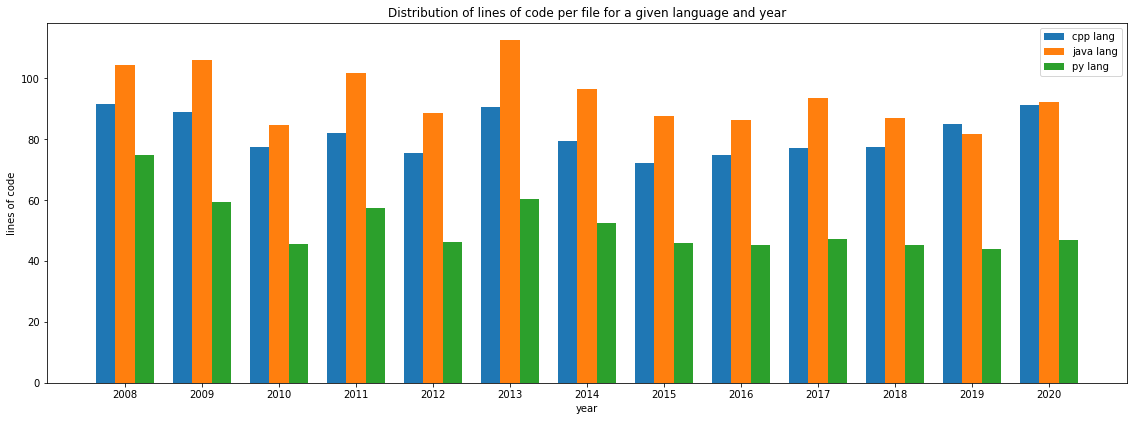

In [14]:
loc_data= {lang: [df[(df.year==year) & (df.lang==lang)].flines.apply(lambda x: str(x).count("\n")).mean()
                  for year in years] 
           for lang in LANGUAGES}
plot_bar(loc_data , 
        "Distribution of lines of code per file for a given language and year", 
        "lines of code", "lines_of_code")

plt.show()

Amount of lines of code for different languages is different, as well, as amount of chars. Usually, programms are not longer, then 100 lines of code. For python language this value is considerably lower (~70)

In [15]:
py_df = df[(df.lang=="py")&(df.year<2017)]

In [16]:
py_df.to_csv("py_df.csv")

## Code for `main_lang` operations

In [17]:


# for each person find the most common language
users = df.groupby(by=["username"])["lang"].agg([("main_lang", lambda x: x.value_counts().index[0]) ])
# dictionary name - language
main_langs = {name: users[users.index==name].main_lang[0] for name in users.index}
# new column with main language
df["main_lang"] = [main_langs[user] for user in df.username]
# rm those, who use non-main language -> no impact
df = df[df.lang==df.main_lang]
# find files per language
users_per_lang = users["main_lang"].value_counts()

len(main_langs)

users_per_lang

#  files for language per year
df.groupby(by=["year"])["lang"].agg([("cpp", lambda x: x[x == "cpp"].count()), 
                                     ("java", lambda x: x[x == "java"].count()), 
                                     ("py", lambda x: x[x == "py"].count()),
                                     ("c", lambda x: x[x == "c"].count()),
                                     ("cs", lambda x: x[x == "cs"].count())])

table = []
for year in tqdm(range(2008, YEAR_LIMIT+1)):
    date = df[df.year==year]
    users = date.groupby(by=["username"])["lang"].agg([("main_lang", lambda x: x.value_counts().index[0]) ])
    users_per_lang = users["main_lang"].value_counts()
    table.append(users_per_lang)
display = pd.DataFrame(columns=LANGUAGES, index=list(range(2008, YEAR_LIMIT+1)),  data=table)
display

display.sum()

df.to_csv("all_5_lang.csv")

KeyboardInterrupt: 